<a href="https://colab.research.google.com/github/manrodri/tensorflow_training/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional_neural_networks_in_tensorflow and Computer Vision

Computer Vision  is the practice of writing algorithms which can discover patterns in images, such as recognizing the cars, people, bicycles,... in a self-driving car.

In [ ]:
# Import dependencies
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import zipfile
import os
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

## Get the data 
The original dataset is from  https://www.vision.ee.ethz.ch/datasets_extra/food-101/, it is also available in [kaggle.com](https://www.kaggle.com/datasets/dansbecker/food-101). For simplicity and save time, udemy instructor (Daniel) did some prepocessing of the dataset (colab notebook available [here](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)).

We start working with only pizza 🍕 and steak

`pizza_steak_url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip'`


In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2023-02-27 19:41:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   171MB/s    in 0.6s    

2023-02-27 19:41:25 (171 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



 ## Inspect the data (become one with it)

 A very crucial step at the begining is really understand the data. In a computer vision problem that involves see many images.

In [ ]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in 'pizza_steak'
There are 2 directories and 0 images in 'pizza_steak/test'
There are 0 directories and 250 images in 'pizza_steak/test/pizza'
There are 0 directories and 250 images in 'pizza_steak/test/steak'
There are 2 directories and 0 images in 'pizza_steak/train'
There are 0 directories and 750 images in 'pizza_steak/train/pizza'
There are 0 directories and 750 images in 'pizza_steak/train/steak'


In [ ]:
!du -h pizza_steak/

15M	pizza_steak/test/pizza
14M	pizza_steak/test/steak
29M	pizza_steak/test
43M	pizza_steak/train/pizza
40M	pizza_steak/train/steak
83M	pizza_steak/train
111M	pizza_steak/


The original food 101 dataset is 5GB in size with 101 labels and houndres of thousands images. For the sake of quick experimentation we start with only two labels and a reduce number of pictures so we can iterate and build from there. 

We experiment, we see what works and what doesn't then we use a larger dataset.


In [ ]:
# Get a list of our images programatly
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

To visualize images (one way to do it) we can get the class programatically then plot images

In [ ]:
import pathlib
import numpy as np

data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # create a list of class_names from the subfolder
class_names


array(['pizza', 'steak'], dtype='<U5')

In [ ]:
# let's visualize our images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + "/" + target_class
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # read image and plot it
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img



Image shape: (512, 512, 3)


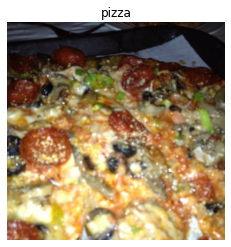

In [ ]:
img = view_random_image(
    target_dir='pizza_steak/train',
    target_class='pizza'
)

In [ ]:
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[  9,   7,   8],
        [  8,   6,   7],
        [  7,   5,   6],
        ...,
        [ 30,  24,  24],
        [ 31,  25,  25],
        [ 31,  25,  25]],

       [[ 13,  11,  12],
        [ 13,  11,  12],
        [ 11,   9,  10],
        ...,
        [ 31,  25,  25],
        [ 32,  26,  26],
        [ 32,  26,  26]],

       [[ 28,  28,  30],
        [ 27,  27,  29],
        [ 25,  25,  27],
        ...,
        [ 32,  26,  26],
        [ 33,  27,  27],
        [ 33,  27,  27]],

       ...,

       [[160, 103,  92],
        [160, 103,  92],
        [171, 112, 104],
        ...,
        [185, 133,  73],
        [183, 128,  71],
        [179, 124,  68]],

       [[184, 125, 111],
        [171, 112,  98],
        [173, 111,  98],
        ...,
        [191, 132,  76],
        [188, 127,  73],
        [185, 122,  71]],

       [[210, 149, 131],
        [189, 128, 110],
        [180, 117, 102],
        ...,
        [199, 136,  8

In [ ]:
tf.constant(img[:,512])

IndexError: ignored

Each point has 3 RGB values. Images are a squaure of pixels. Therefore we have a 3D matrix (AKA Tensor 3D) representing each point (x,y,rgb).

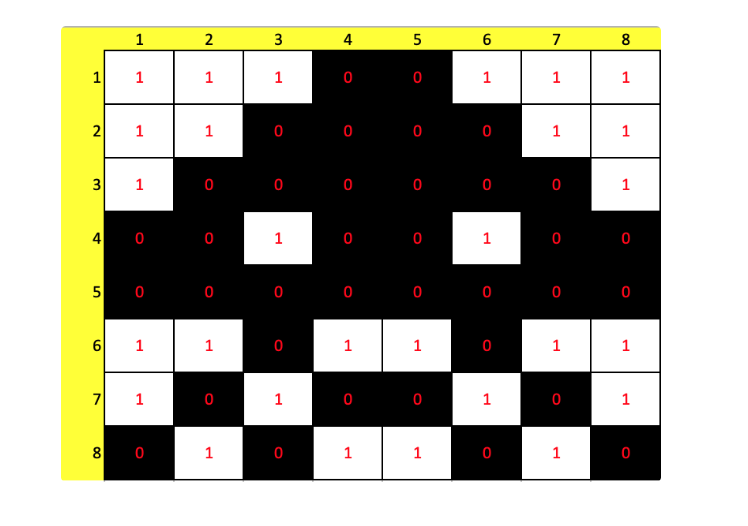

In the simplified example shown above, The rgb is changed by a binary choice (white or black => 1 or 0). Thus the shape of this image is:
8 * 8 * 2. thefereo 64 bits (1/0 -> that is one bit)

We could pass this images directly to the CNN as inputs but remember Normalization is is critical to achieve good results in our models.

**REMAINDER** normalization is to have all our input values in ranges of 0 an 1

In [ ]:
norm_img = img/255 # each pixel is a vector with values ranging from 0 to 255 (8 bits) 

In [ ]:
norm_img

array([[[0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        ...,
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314]],

       [[0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        ...,
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314]],

       [[0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        ...,
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314],
        [0.        , 0.        , 0.00784314]],

       ...,

       [[0.00392157, 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of [red, green and blue (RGB) pixels](https://en.wikipedia.org/wiki/RGB_color_model).

You'll notice all of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value `red=0, green=0, blue=255` will look very blue.

So when we build a model to differentiate between our images of `pizza` and `steak`, it will be finding patterns in these different pixel values which determine what each class looks like.

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

## Build a CNN end to end

We're going to work backwards from a build NN to explain single elements in it.

- load images
- Preprocess images
- Build CNN
- Compile CNN
- Fit the CNN to our trainig data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

# Preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    target_size=(224,224),
    class_mode='binary',
    seed=42
    )

valid_data = valid_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    target_size=(224,224),
    class_mode='binary',
    seed=42
)

# Build CNN model (Same as Tini VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential(
    [tf.keras.layers.Conv2D(filters=10,
                               kernel_size=3,
                               activation='relu',
                               input_shape=(224,224,3)
                               ),
     tf.keras.layers.Conv2D(10,3,activation='relu'), # This is the same as above
     tf.keras.layers.MaxPool2D(pool_size=2,
                               padding='valid'),
     
     tf.keras.layers.Conv2D(10,3,activation='relu'),
     tf.keras.layers.MaxPool2D(pool_size=2,
                               padding='valid'),
     
     tf.keras.layers.Conv2D(10,3,activation='relu'),
     tf.keras.layers.Conv2D(10,3,activation='relu'), # This is the same as above
     tf.keras.layers.MaxPool2D(pool_size=2,
                               padding='valid'),
     
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1, activation='sigmoid')
     
    ]
)

# Compile the CNN, this is exactly the same as we did in the second chapter.
model_1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
history_1 = model_1.fit(train_data,  # the preprocessing creates data and labels automotically for us
                        epochs=5,
                        steps_per_epoch=len(train_data), # because we have len(train_data) batches per train_data
                        validation_data=valid_data, # pass validation directly 
                        validation_steps=len(valid_data), # same as steps per epoch for the training data
                        verbose=1)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 12s 196ms/step - loss: 0.5832 - accuracy: 0.7000 - val_loss: 0.7555 - val_accuracy: 0.5760
Epoch 2/5
47/47 [==============================] - 10s 212ms/step - loss: 0.4839 - accuracy: 0.7760 - val_loss: 0.3949 - val_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 10s 208ms/step - loss: 0.4218 - accuracy: 0.8133 - val_loss: 0.3583 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 10s 210ms/step - loss: 0.3970 - accuracy: 0.8353 - val_loss: 0.3288 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 9s 199ms/step - loss: 0.3646 - accuracy: 0.8413 - val_loss: 0.3191 - val_accuracy: 0.8580


len(train_data) = 47

Images found =>

                1500 belonging to 2 classes (train)
                500 belonging to 2 classes (test)

1500/32 ~ 47

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

The [CNN explainer website](https://poloclub.github.io/cnn-explainer/)is an execellent resource to play around.

## Using the same model as before

To examplify how neural networks can be adapted to many different problems, let's see how a binary classification model we've previously built might work with our data.

> 🔑 **Note:** If you haven't gone through the previous classification notebook, no troubles, we'll be bringing in the a simple 4 layer architecture used to separate dots replicated from the [TensorFlow Playground environment](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75075&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

We can use all of the same parameters in our previous model except for changing two things:
* **The data** - we're now working with images instead of dots.
* **The input shape** - we have to tell our neural network the shape of the images we're working with.
  * A common practice is to reshape images all to one size. In our case, we'll resize the images to `(224, 224, 3)`, meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 215ms/step - loss: 1.2197 - accuracy: 0.4947 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 10s 210ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 10s 208ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 10s 210ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 10s 210ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


Hmmm... our model ran but it doesn't seem like it learned anything. It only reaches 50% accuracy on the training and test sets which in a binary classification problem is as good as guessing.

Let's see the architecture.

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Wow. One of the most noticeable things here is the much larger number of parameters in `model_2` versus `model_1`.

`model_2` has 602,141 trainable parameters where as `model_1` has only 31,101. And despite this difference, `model_1` still far and large out performs `model_2`.

> 🔑 **Note:** You can think of trainable parameters as *patterns a model can learn from data*. Intuitiely, you might think more is better. And in some cases it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image**. So even though there are less learnable parameters in our convolutional neural network, these are often more helpful in decphering between different **features** in an image.

Since our previous model didn't work, do you have any ideas of how we might make it work?

How about we increase the number of layers? 

And maybe even increase the number of neurons in each layer?

More specifically, we'll increase the number of neurons (also called hidden units) in each dense layer from 4 to 100 and add an extra layer.

> 🔑 **Note:** Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the **complexity** of your model.

In [ ]:
tf.random.set_seed(42)
model_3 = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(224,224,3)),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model_3.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_3 = model_3.fit(train_data,
            epochs=10,
            steps_per_epoch=len(train_data),
            validation_data=valid_data, 
            validation_steps=len(valid_data)
            )

Epoch 1/10
47/47 [==============================] - 11s 190ms/step - loss: 4.5063 - accuracy: 0.6313 - val_loss: 1.2087 - val_accuracy: 0.7580
Epoch 2/10
47/47 [==============================] - 9s 195ms/step - loss: 1.0482 - accuracy: 0.7140 - val_loss: 0.5194 - val_accuracy: 0.8180
Epoch 3/10
47/47 [==============================] - 9s 193ms/step - loss: 0.7387 - accuracy: 0.7233 - val_loss: 1.0465 - val_accuracy: 0.6220
Epoch 4/10
47/47 [==============================] - 8s 177ms/step - loss: 0.7344 - accuracy: 0.7420 - val_loss: 0.9374 - val_accuracy: 0.6340
Epoch 5/10
47/47 [==============================] - 9s 196ms/step - loss: 0.7011 - accuracy: 0.7473 - val_loss: 1.0704 - val_accuracy: 0.6020
Epoch 6/10
47/47 [==============================] - 9s 194ms/step - loss: 0.5552 - accuracy: 0.7733 - val_loss: 0.7702 - val_accuracy: 0.6260
Epoch 7/10
47/47 [==============================] - 9s 195ms/step - loss: 0.5680 - accuracy: 0.7633 - val_loss: 0.4847 - val_accuracy: 0.7740
Epoch

In [ ]:
# trainable params
602141 / 10591

56.85402700406005

## End to end example deep-dive



1.   Become one with the data
2.   Preprocess the data (normalization and create minibatches is the main work here)
3.   Create a model (start  with a baseline)
4.   Fit the model
5.   Evaluate the model
6.   Adjust different params
7.   Repeat until satisfied. Experiment, experiment, experiment



### 1. Become one with the data

In [ ]:
# let's visualize our images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + "/" + target_class
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # read image and plot it
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img



Image shape: (382, 512, 3)
Image shape: (512, 512, 3)


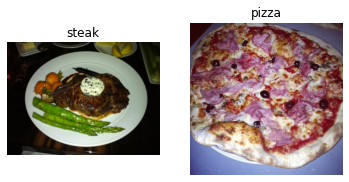

In [ ]:
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image('pizza_steak/train', 'steak')
plt.subplot(1,2,2)
pizze_img = view_random_image('pizza_steak/train', 'pizza')

### 2. Prepocess the data

In [ ]:
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'

Our next step is to turn our data into batches. 

A batch is a smll subset of data. Rather than look at our 15K images; our model only looks at 32 at a time. It does this for two reasons:
1. 15K images does not fit in memory of our hardware (we could potentially have millions of images)
2. Trying to lear the patterns in 15K images in one hit could result in the model not being able to lear very well.


why 32? Because 32 is good for your health...

https://twitter.com/ylecun/status/989610208497360896?lang=en


In [ ]:
# Create generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#  https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen  = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Load in our image data from directory and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224,224),
                                               class_mode='binary',
                                               batch_size=32)

Found 1500 images belonging to 2 classes.


In [ ]:
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             class_mode='binary',
                                             target_size=(224,224),
                                             batch_size=32)

Found 500 images belonging to 2 classes.


In [ ]:
# Get a sample of a train data batch
images, labels = train_data.next()

In [ ]:
type(images)

numpy.ndarray

In [ ]:
len(images)

32

In [ ]:
images.ndim

4

In [ ]:
images.shape

(32, 224, 224, 3)

In [ ]:
labels.shape

(32,)

In [ ]:
# how many batches in train_data?
len(train_data)

47

Therefore, we now have 47 batches of images (224,224,3) being the batch size 32. All pixels are between 0 and 1.


In [ ]:
images[0].shape

(224, 224, 3)

In [ ]:
images[0]

array([[[0.2901961 , 0.25490198, 0.27450982],
        [0.28627452, 0.2509804 , 0.27058825],
        [0.29411766, 0.25882354, 0.2784314 ],
        ...,
        [0.25882354, 0.31764707, 0.44705886],
        [0.2627451 , 0.32156864, 0.45098042],
        [0.27450982, 0.33333334, 0.46274513]],

       [[0.2901961 , 0.2627451 , 0.2901961 ],
        [0.28627452, 0.25882354, 0.28627452],
        [0.2901961 , 0.2627451 , 0.2901961 ],
        ...,
        [0.28627452, 0.3529412 , 0.454902  ],
        [0.29411766, 0.3647059 , 0.45882356],
        [0.3019608 , 0.37254903, 0.4666667 ]],

       [[0.28627452, 0.25882354, 0.28627452],
        [0.28235295, 0.25490198, 0.28235295],
        [0.2901961 , 0.2627451 , 0.2901961 ],
        ...,
        [0.30980393, 0.3921569 , 0.4666667 ],
        [0.33333334, 0.4156863 , 0.4901961 ],
        [0.3254902 , 0.40784317, 0.47450984]],

       ...,

       [[0.39607847, 0.20392159, 0.07450981],
        [0.2509804 , 0.06666667, 0.04313726],
        [0.20784315, 0

In [ ]:
# View the first batch of labels
labels

array([0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [ ]:
len(labels)

32

### 3. Create a model (start with a baseline)

You might be wondering what your default model architecture should be.

And the truth is, there's many possible answers to this question.

A simple heuristic for computer vision models is to use the model architecture which is performing best on [ImageNet](https://www.image-net.org/) (a large collection of diverse images to benchmark different computer vision models).

However, to begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

> 🔑 **Note:** In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In our case, let's take a smaller version of the model that can be found on the [CNN explainer website](https://poloclub.github.io/cnn-explainer/) (`model_1` from above) and build a 3 layer convolutional neural network.

In [ ]:
# baseline
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
from keras.optimizers.optimizer_experimental.adadelta import optimizer
tf.random.set_seed(42)
model_4 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224,224,3)),
    Conv2D(10,3, activation='relu'),
    Conv2D(10,3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')

])



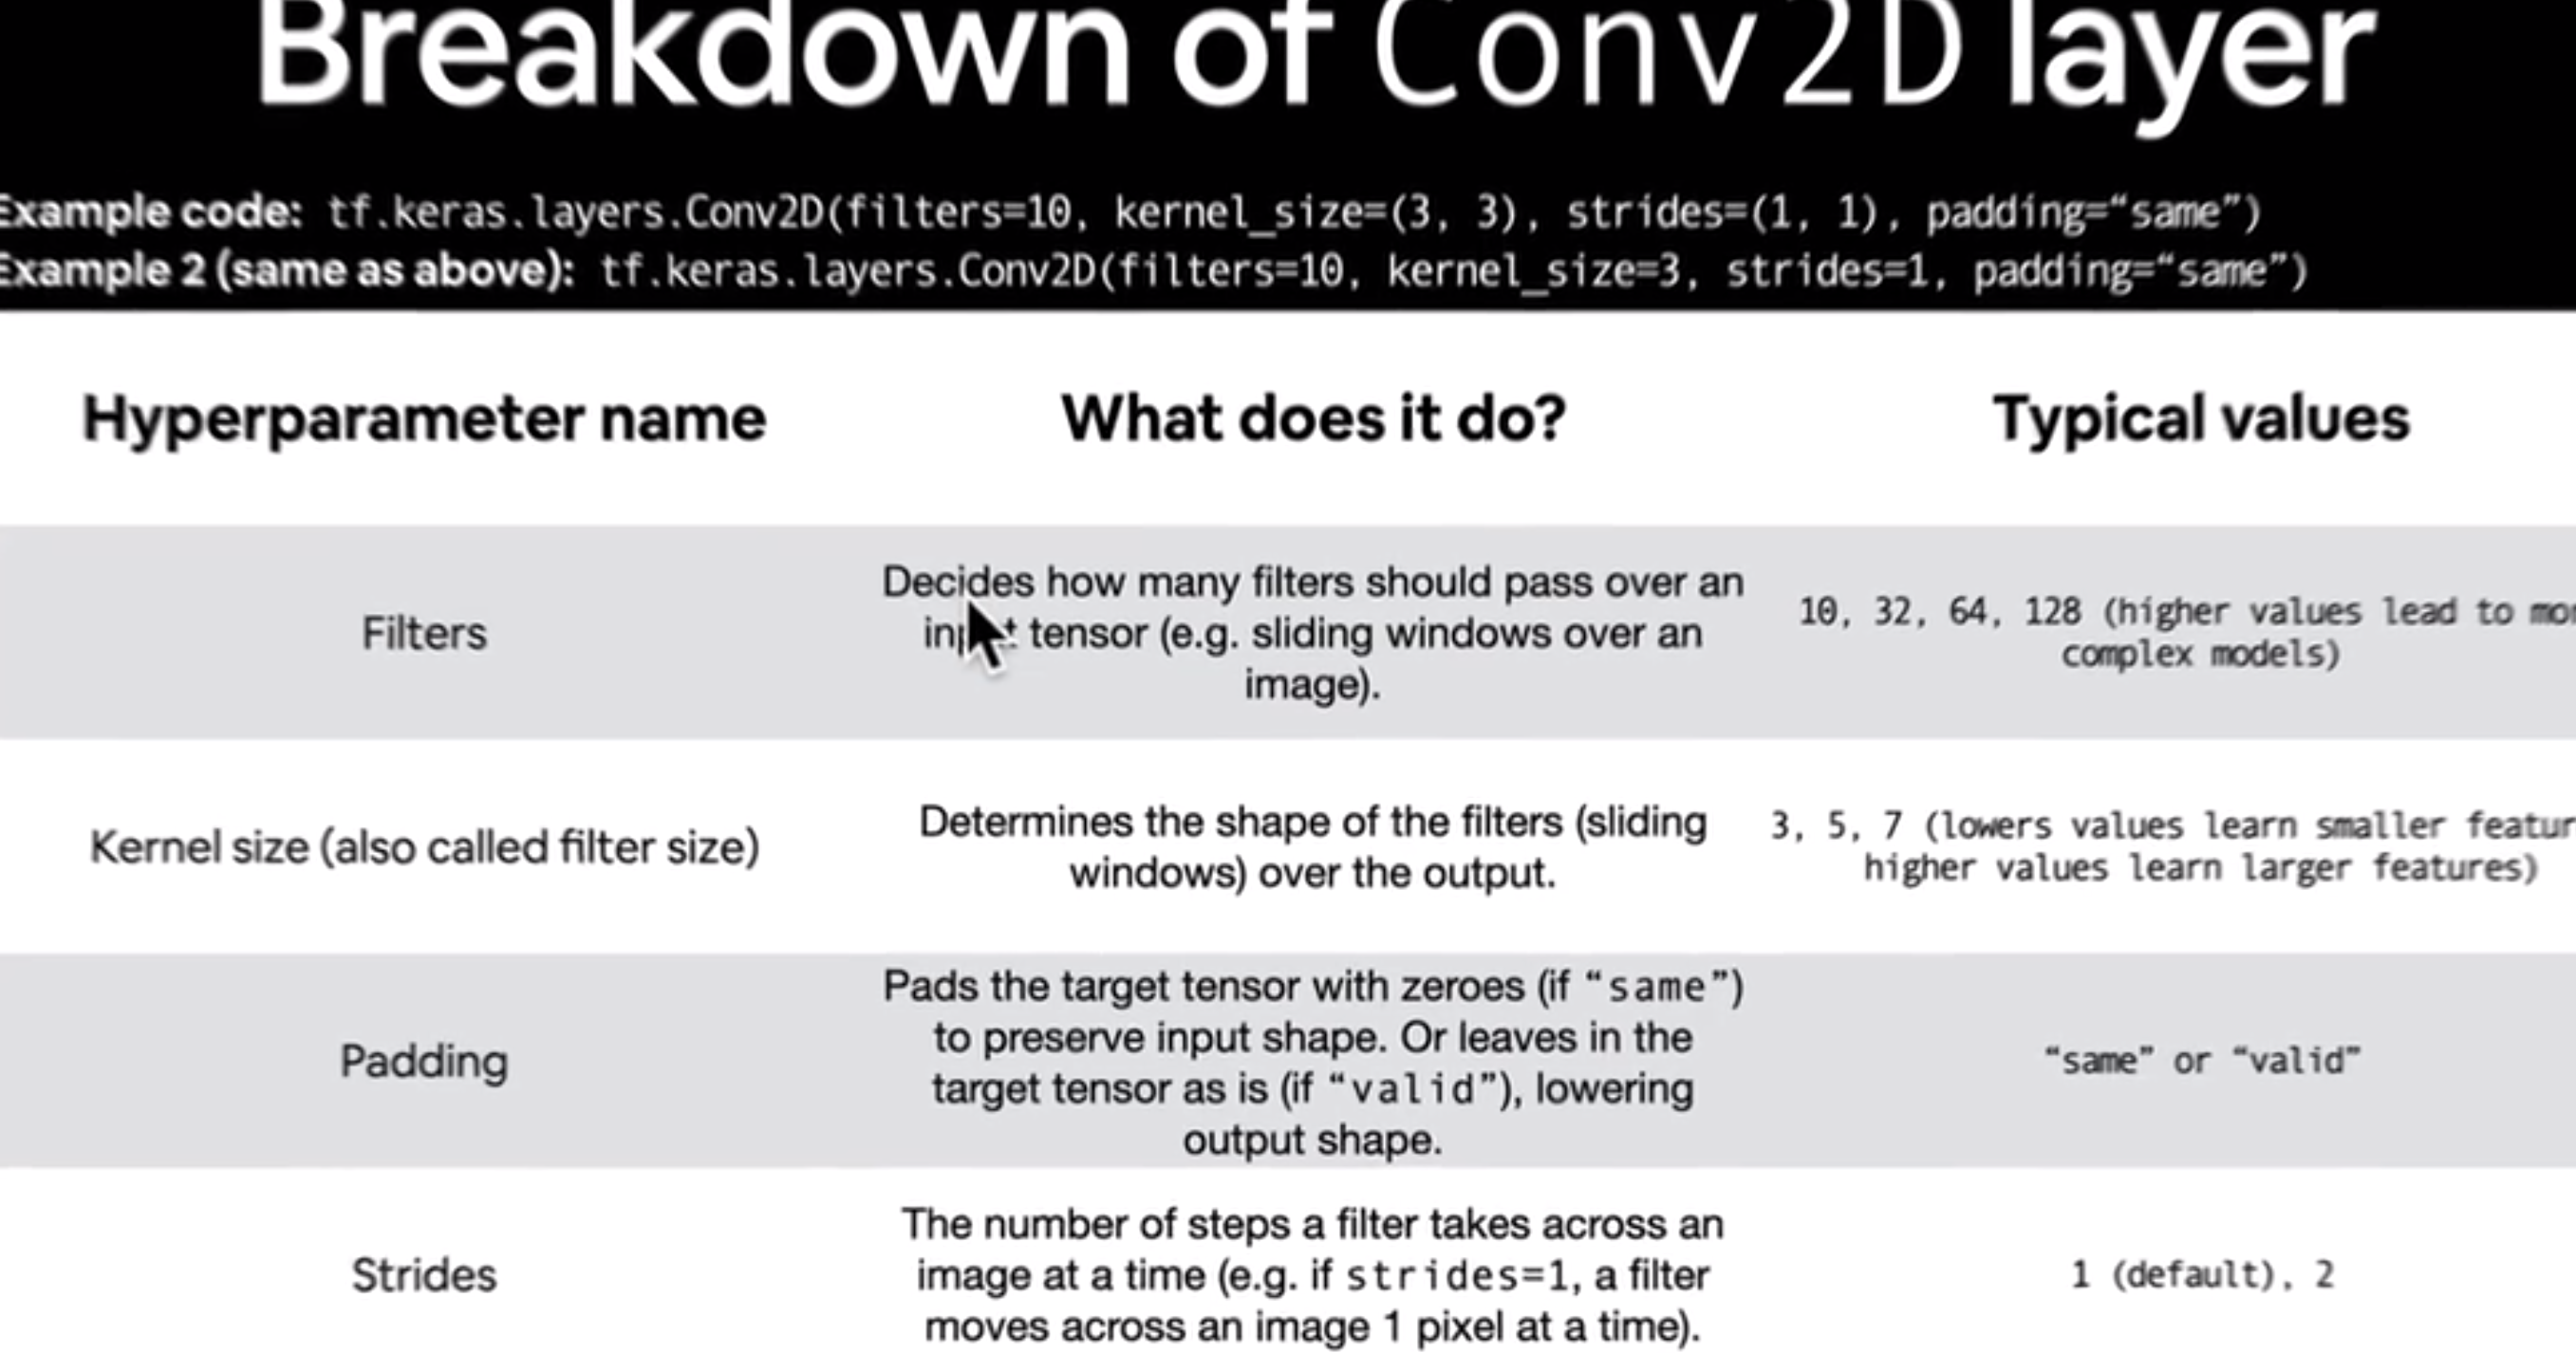

**Practice**: Understand what's going on in a Conv2D layer by going through the CNN explainer website and watching Dr. Ryan Ahmed [lectures](https://www.udemy.com/course/practical-aws-sagemaker-6-real-world-case-studies/learn/lecture/20041818#overview).

In [ ]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten (Flatten)           (None, 475240)            0         
                                                                 
 dense (Dense)               (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_4.compile(
    loss=binary_crossentropy,
    optimizer=Adam(),
    metrics=['accuracy']
)



In [ ]:
# Check the lengths of training and test data generator
len(test_data), len(train_data)

(16, 47)

In [ ]:
# Fit the model
history_4 = model_4.fit(
    train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data, 
            validation_steps=len(test_data)
)

Epoch 1/5
47/47 [==============================] - 22s 228ms/step - loss: 0.6124 - accuracy: 0.6800 - val_loss: 0.5314 - val_accuracy: 0.7220
Epoch 2/5
47/47 [==============================] - 10s 214ms/step - loss: 0.4122 - accuracy: 0.8100 - val_loss: 0.4998 - val_accuracy: 0.7420
Epoch 3/5
47/47 [==============================] - 10s 213ms/step - loss: 0.2514 - accuracy: 0.9153 - val_loss: 0.3682 - val_accuracy: 0.8280
Epoch 4/5
47/47 [==============================] - 10s 207ms/step - loss: 0.1269 - accuracy: 0.9567 - val_loss: 0.4713 - val_accuracy: 0.7860
Epoch 5/5
47/47 [==============================] - 10s 203ms/step - loss: 0.0397 - accuracy: 0.9940 - val_loss: 0.5289 - val_accuracy: 0.7900


In [ ]:
model_1.evaluate(test_data)

NameError: ignored

In [ ]:
model_4.evaluate(test_data)

16/16 [==============================] - 4s 225ms/step - loss: 0.5212 - accuracy: 0.7680


[0.5211727619171143, 0.7680000066757202]

## 5. Evaluate our model



*   Accuracy
*   Precission
*   Recall
*   F1-score
*   Confusion metrix

Dr Ryan Ahmed lectures and  Aurelien Geron [book](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975/?_encoding=UTF8&pd_rd_w=kV5lb&content-id=amzn1.sym.ef3907ff-f91d-4263-9e4a-2471c52bf60e&pf_rd_p=ef3907ff-f91d-4263-9e4a-2471c52bf60e&pf_rd_r=CAZ9DVT4672BB110F5MS&pd_rd_wg=1QG3W&pd_rd_r=e36a8494-29bb-4bfd-ad60-31f9eae7a061&ref_=pd_gw_ci_mcx_mr_hp_atf_m) have excellent expalations on this



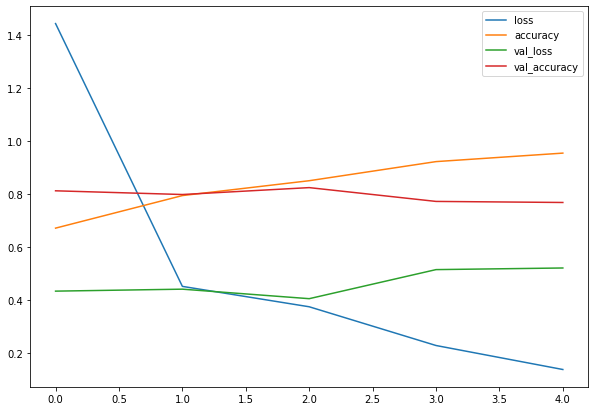

In [ ]:
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10,7))

In [ ]:
# plot validation and training curves separatedly
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics
  """
  import pandas as pd
  import matplotlib.pyplot as plt

  history_df = pd.DataFrame(history.history)

  loss = history_df.loss
  accuracy = history_df.accuracy
  val_loss = history_df.val_loss
  val_accuracy = history_df.val_accuracy

  epochs = range(len(history.history["loss"]))

  # plot loss
  plt.figure()
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='validation_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()



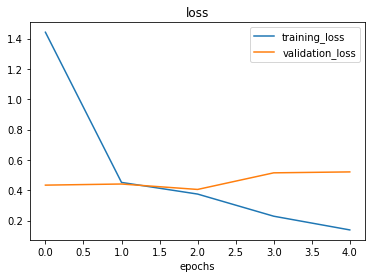

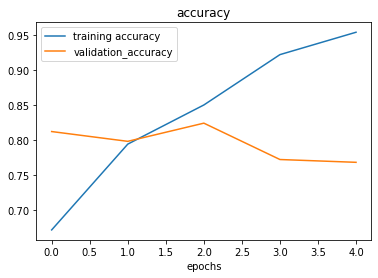

In [ ]:
plot_loss_curves(history_4)

Our model is **overfitting**

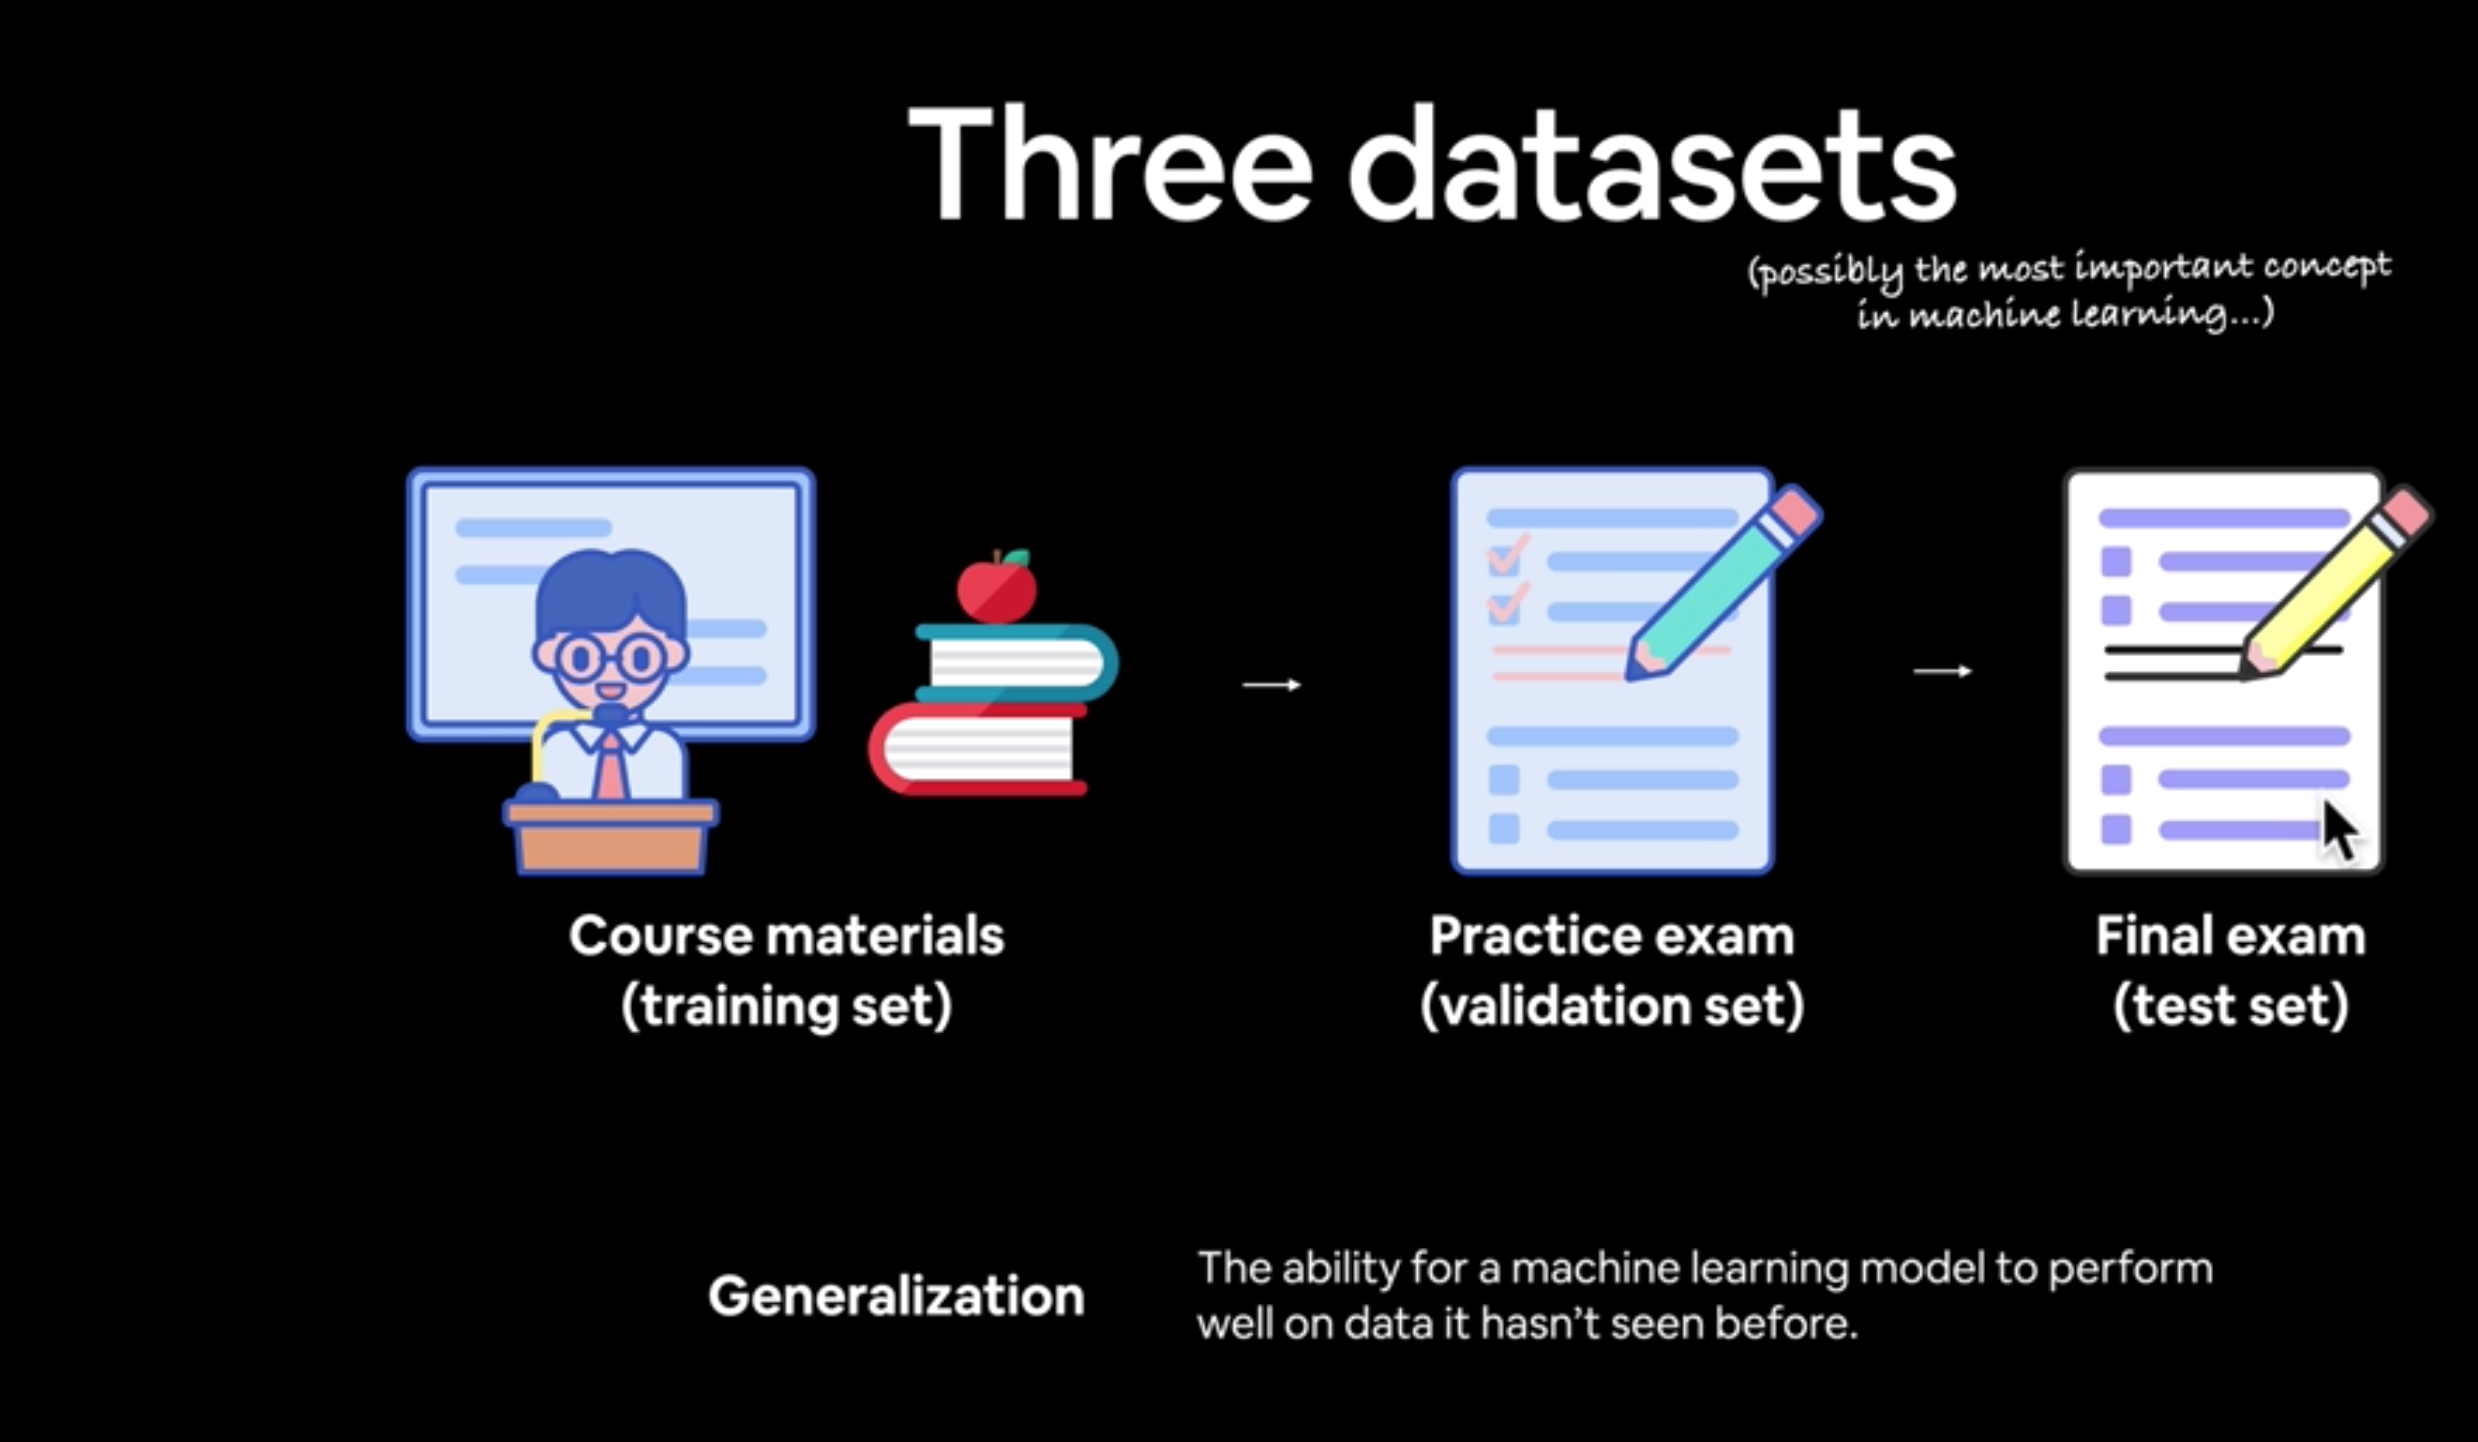

Hmm, judging by our loss curves, it looks like our model is **overfitting** the training dataset.

> 🔑 **Note:** When a model's **validation loss starts to increase**, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus its ability to generalize to unseen data will be diminished

### 6. Adjust the model parameters

Fitting a ML model comes in three steps:
1. Create a baseline
2. Beat the baseline by overfitting a larger model
3. Reduce overfitting

Ways to induce overfitting:
* increase the complexity of the model
  * Increase the number of conv layers
  * Increase the number of conf filters
  * Add another dense layer output of our flattened layer 

Reduce overfitting:
* Add data augmentation
* Add regularization layers (MaxPool2D)
* Add more data... 

In [ ]:
# new baseline
model_5 = Sequential([
    Conv2D(10, 3,strides=1,
           padding='valid',
           activation=tf.keras.activations.relu,
           input_shape=(224,224,3)),
    MaxPool2D(pool_size=2),
    Conv2D(10,3, activation=tf.keras.activations.relu),
    MaxPool2D(pool_size=2),
    Conv2D(10,3, activation=tf.keras.activations.relu),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation=tf.keras.activations.sigmoid)

]
)

In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [ ]:
model_5.summary(), model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 10)     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 10)      

(None, None)

In [ ]:
model_5.compile(
    loss=binary_crossentropy,
    optimizer=Adam(),
    metrics=['accuracy']
)
history_5 = model_5.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data, 
    validation_steps=len(test_data)
)

Epoch 1/5
47/47 [==============================] - 22s 238ms/step - loss: 0.6235 - accuracy: 0.6933 - val_loss: 0.4830 - val_accuracy: 0.8020
Epoch 2/5
47/47 [==============================] - 10s 216ms/step - loss: 0.4816 - accuracy: 0.7820 - val_loss: 0.4679 - val_accuracy: 0.7560
Epoch 3/5
47/47 [==============================] - 10s 215ms/step - loss: 0.4427 - accuracy: 0.8020 - val_loss: 0.3670 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 9s 198ms/step - loss: 0.4027 - accuracy: 0.8267 - val_loss: 0.3468 - val_accuracy: 0.8360
Epoch 5/5
47/47 [==============================] - 10s 222ms/step - loss: 0.3849 - accuracy: 0.8367 - val_loss: 0.3179 - val_accuracy: 0.8660


Do you notice what's going on here with the output shape in each `MaxPooling2D` layer?

It gets halved each time. This is effectively the `MaxPooling2D` layer taking the outputs of each Conv2D layer and saying "I only want the most important features, get rid of the rest".

The bigger the `pool_size` parameter, the more the max pooling layer will squeeze the features out of the image. However, too big and the model might not be able to learn anything.

The results of this pooling are seen in a major reduction of total trainable parameters (8,861 in `model_5` and 477,431 in `model_4`).

Time to check out the loss curves.

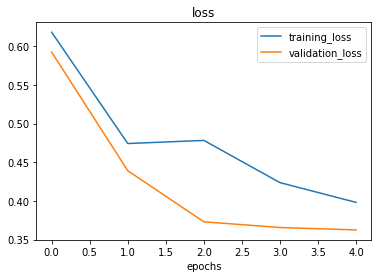

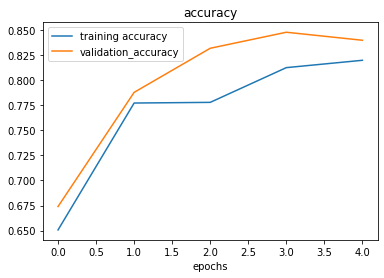

In [ ]:
plot_loss_curves(history_5)

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

Time to dig into our bag of tricks and try another method of overfitting prevention, data augmentation.

First, we'll see how it's done with code then we'll discuss what it's doing.

To implement data augmentation, we'll have to reinstantiate our [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instances.

In [ ]:
# Create ImageDataGenerator training with data augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=.2,
    shear_range=.2,
    zoom_range=.2,
    width_shift_range=.2,
    height_shift_range=.3,
    horizontal_flip=True
)

In [ ]:
# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

> 🤔 **Question:** What's data augmentation?

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs. steak application, not all of the images our users take might be in similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

> 🔑 **Note:** Data augmentation is usally only performed on the training data. Using the `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

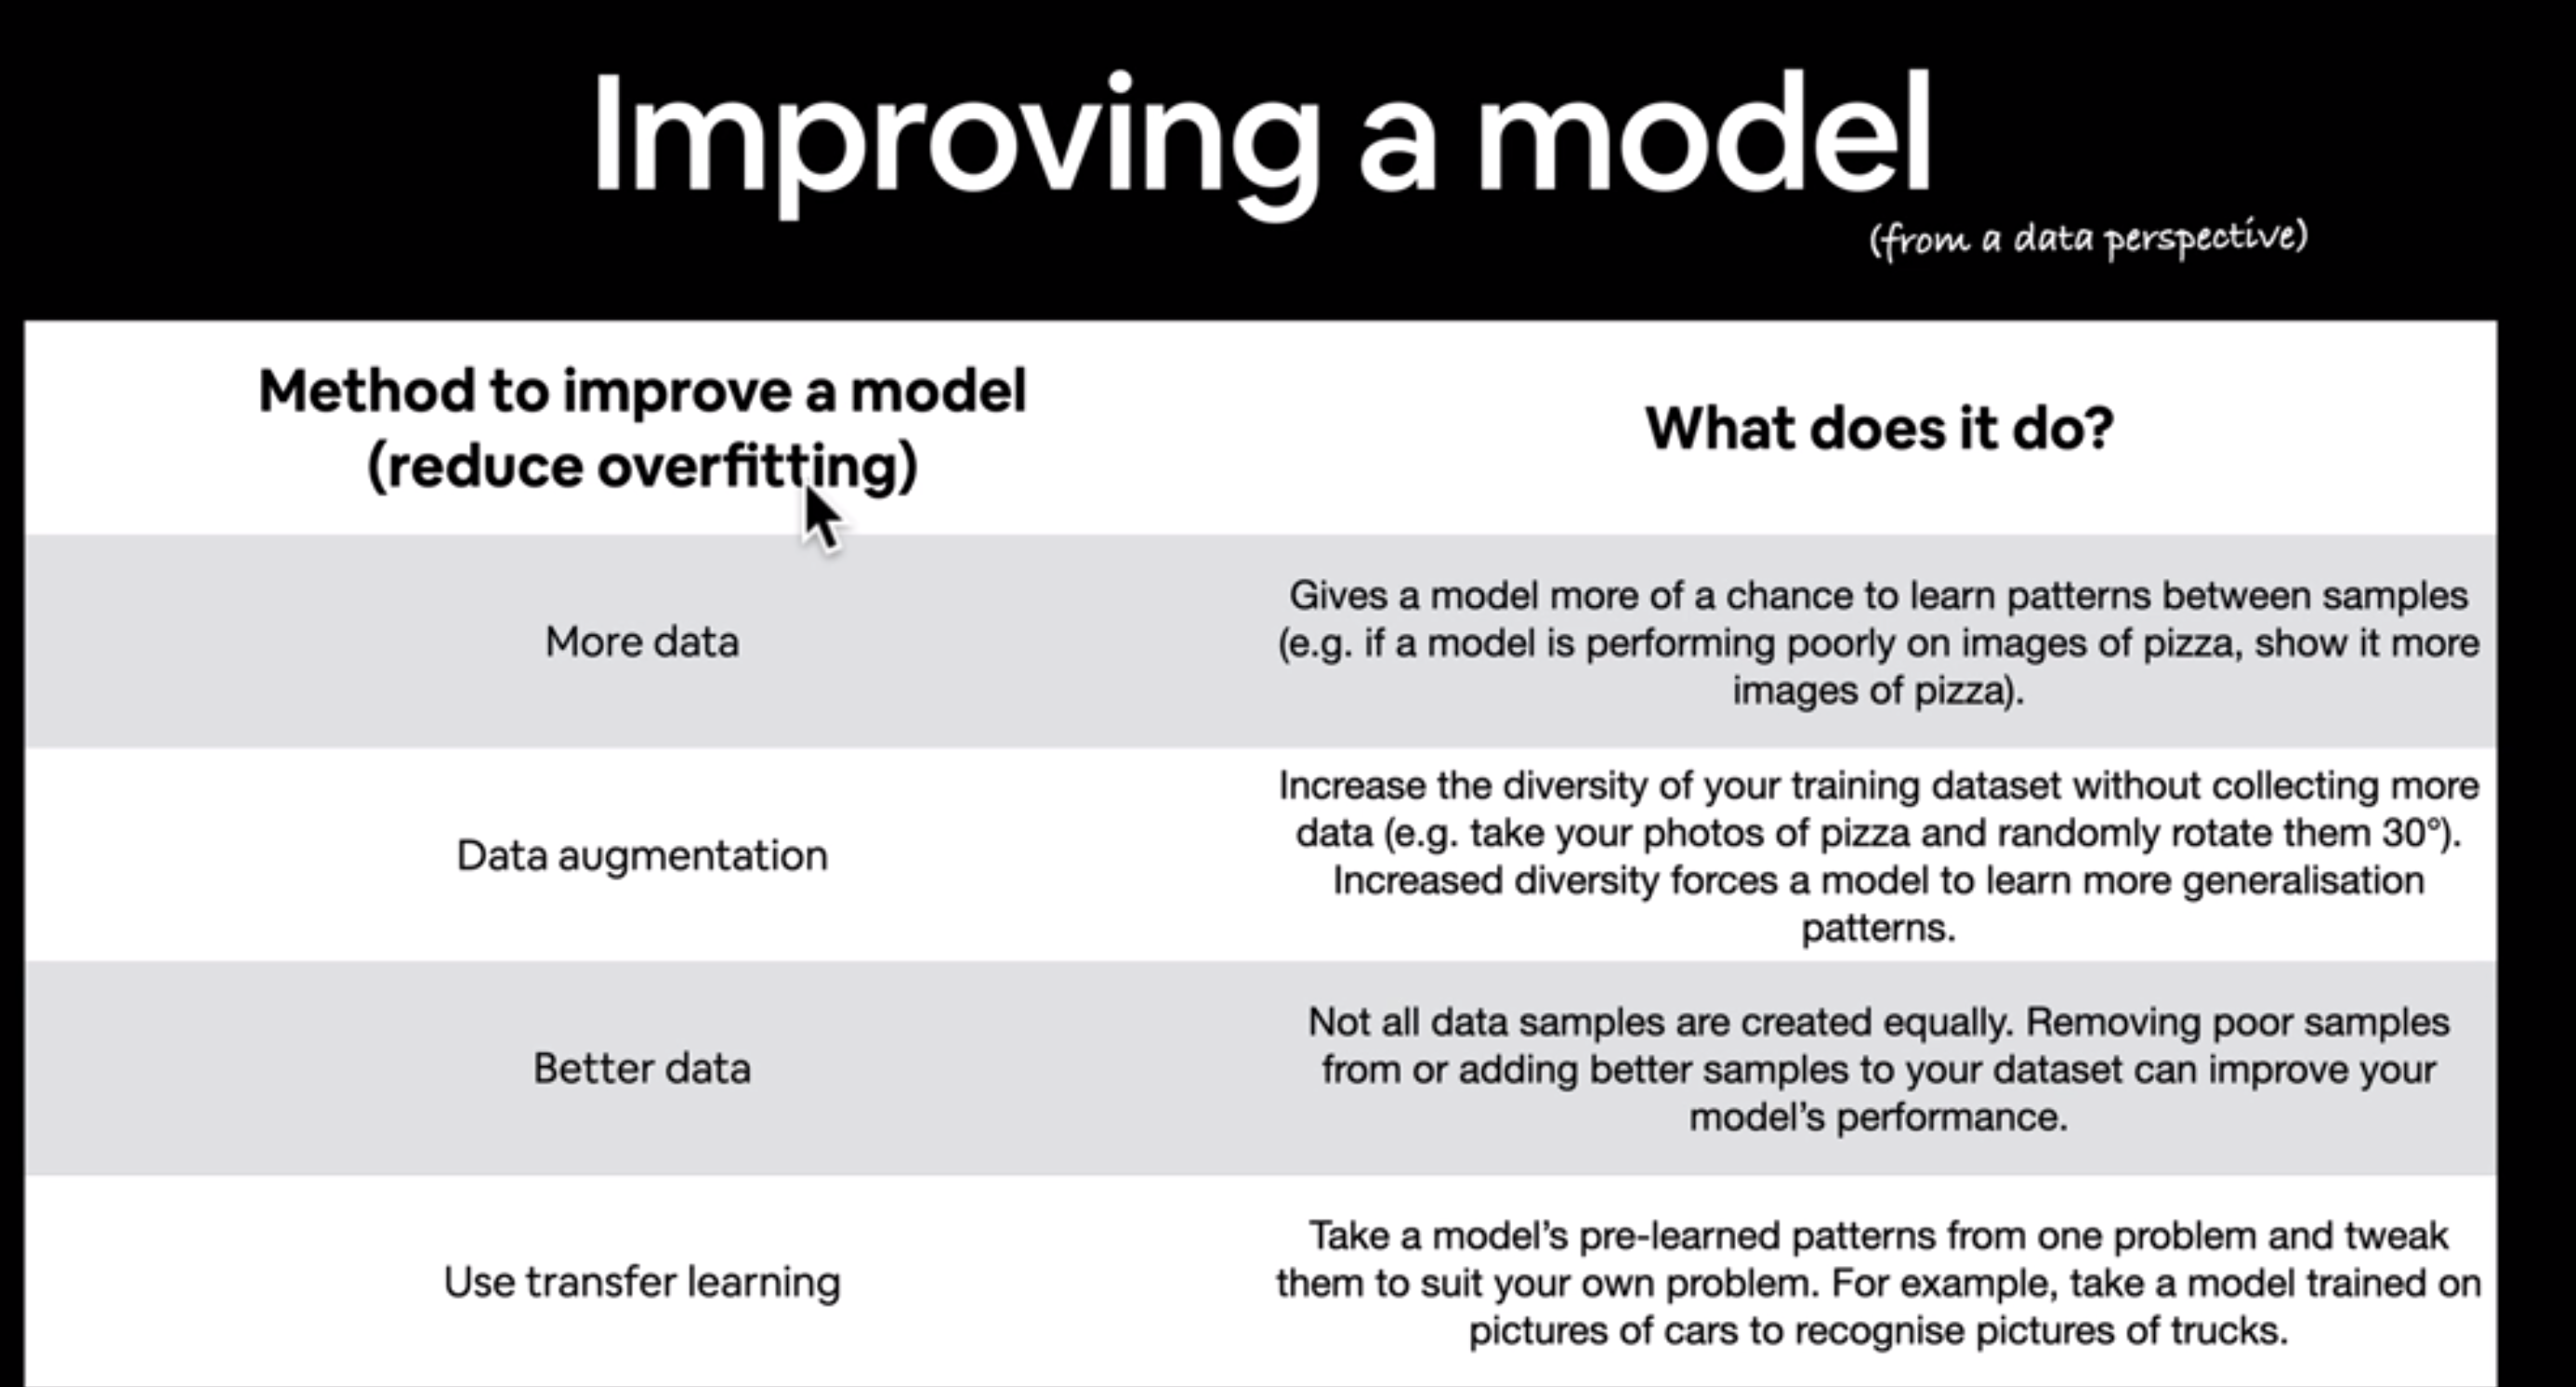

Let's write some code to visualize data augmentation

In [ ]:
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

In [ ]:
def create_data_batches(data_gen, data_dir, image_size, class_mode='binary', batch_size=32, seed=None, shuffle=True):
  '''
  Create data batches from a datagen object
  '''
  return data_gen.flow_from_directory(
      data_dir,
      target_size=image_size,
      batch_size=batch_size,
      class_mode=class_mode,
      shuffle=shuffle,
      seed=seed
  )

In [ ]:

IMG_SIZE=(224,224)
print(f"Augmented training data")

train_data_aug = create_data_batches(train_datagen_augmented,
                    data_dir=train_dir,
                    image_size=IMG_SIZE,
                    class_mode='binary',
                    shuffle=False,
                    )

#  Create non-augmented train data batches
print(f"Non-augmented training data")
# train_data = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=IMG_SIZE,
#     batch_size=32,
#     shuffle=False,
#     seed=42,
#     class_mode='binary'
# )
train_data = create_data_batches(train_datagen,
                    train_dir,
                    image_size=IMG_SIZE,
                    class_mode='binary',
                    batch_size=32,
                    shuffle=False
                    )

Augmented training data
Found 1500 images belonging to 2 classes.
Non-augmented training data
Found 1500 images belonging to 2 classes.


In [ ]:
print(f"Non-Augmented test data")
test_data = create_data_batches(test_datagen,
                    data_dir=test_dir,
                    image_size=IMG_SIZE,
                    class_mode='binary',
                    shuffle=False,
)



Non-Augmented test data
Found 500 images belonging to 2 classes.


In [ ]:
# Get data batches . Labels are not augmented, only images
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_aug.next()

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

image number: 23
augmented image number: 23


(-0.5, 223.5, 223.5, -0.5)

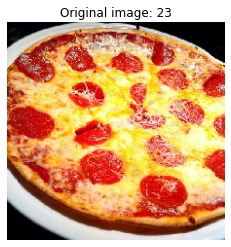

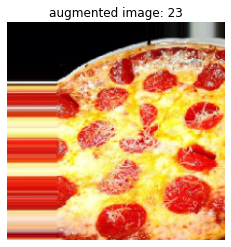

In [ ]:
# visualize original and augmented image
import random
random_number = random.randint(0, 32)
print(f"image number: {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original image: {random_number}" )
plt.axis(False)
plt.figure()
print(f"augmented image number: {random_number}")
plt.imshow(augmented_images[random_number])
plt.title(f"augmented image: {random_number}")
plt.axis(False)


 Build a model using augmented data

In [ ]:
model_6 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10,3, activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(10,3, activation='relu'),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_6.summary(), model_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 10)      

(None, None)

In [ ]:
model_6.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
history_6 = model_6.fit(
    train_data_augmented,
    epochs=5,
    steps_per_epoch=len(train_data_augmented),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
47/47 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.5660

47/47 [==============================] - 24s 512ms/step - loss: 0.6980 - accuracy: 0.5660 - val_loss: 0.6560 - val_accuracy: 0.7140
Epoch 2/5
47/47 [==============================] - 23s 481ms/step - loss: 0.6855 - accuracy: 0.5733
Epoch 3/5
47/47 [==============================] - 22s 476ms/step - loss: 0.6679 - accuracy: 0.6247
Epoch 4/5
47/47 [==============================] - 20s 432ms/step - loss: 0.6438 - accuracy: 0.6693
Epoch 5/5
47/47 [==============================] - 21s 456ms/step - loss: 0.6554 - accuracy: 0.6187


In [ ]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 26s 519ms/step - loss: 0.7145 - accuracy: 0.4880 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 24s 515ms/step - loss: 0.6945 - accuracy: 0.4993 - val_loss: 0.6860 - val_accuracy: 0.5020
Epoch 3/5
47/47 [==============================] - 23s 499ms/step - loss: 0.6872 - accuracy: 0.5947 - val_loss: 0.6716 - val_accuracy: 0.5320
Epoch 4/5
47/47 [==============================] - 26s 547ms/step - loss: 0.6765 - accuracy: 0.5713 - val_loss: 0.6268 - val_accuracy: 0.6280
Epoch 5/5
47/47 [==============================] - 30s 642ms/step - loss: 0.6313 - accuracy: 0.6413 - val_loss: 0.7502 - val_accuracy: 0.5360


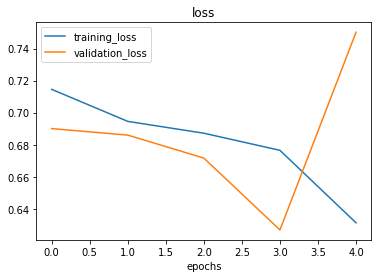

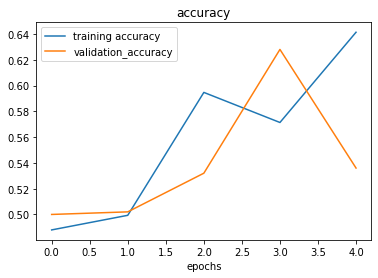

In [ ]:
plot_loss_curves(history_6)

let's shuffle augmented training_data and see what happens

In [ ]:
shufllfed_augmented_data = create_data_batches(
    train_datagen_augmented,
                    data_dir=train_dir,
                    image_size=IMG_SIZE,
                    class_mode='binary',
                    shuffle=True,
)

Found 1500 images belonging to 2 classes.


In [ ]:
augmented_images, augmented_lables = shufllfed_augmented_data.next()

In [ ]:
history_6_shuffled = model_6.fit(
    shufllfed_augmented_data,
    epochs=5,
    steps_per_epoch=len(shufllfed_augmented_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
47/47 [==============================] - 24s 510ms/step - loss: 0.4788 - accuracy: 0.7713 - val_loss: 0.3699 - val_accuracy: 0.8400
Epoch 2/5
47/47 [==============================] - 23s 491ms/step - loss: 0.4921 - accuracy: 0.7647 - val_loss: 0.3589 - val_accuracy: 0.8520
Epoch 3/5
47/47 [==============================] - 23s 487ms/step - loss: 0.4572 - accuracy: 0.7967 - val_loss: 0.3734 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 24s 512ms/step - loss: 0.4611 - accuracy: 0.7913 - val_loss: 0.3516 - val_accuracy: 0.8500
Epoch 5/5
47/47 [==============================] - 24s 513ms/step - loss: 0.4462 - accuracy: 0.7920 - val_loss: 0.3657 - val_accuracy: 0.8340


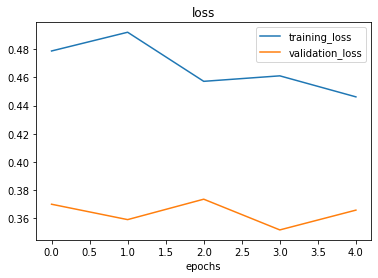

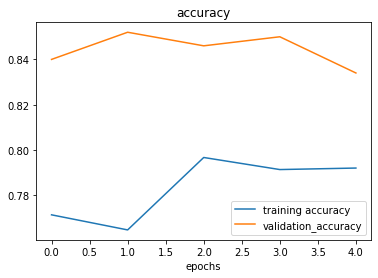

In [ ]:
plot_loss_curves(history_6_shuffled)

### 7. Repeat until satisified

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:
* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as **hyperparameter tuning**.

You can think of hyperparameter tuning as simialr to adjusting the settings on your oven to cook your favourite dish. Although your oven does most of the cooking for you, you can help it by tweaking the dials.

Let's go back to right where we started and try our original model (`model_1` or the TinyVGG architecture from [CNN explainer](https://poloclub.github.io/cnn-explainer/)).

### 7. Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's **transfer learning**.

However, we'll save that for the next notebook where you'll see how rather than design our own models from scratch we leverage the patterns another model has learned for our own task.

In the meantime, let's make a prediction with our trained multi-class **model**.


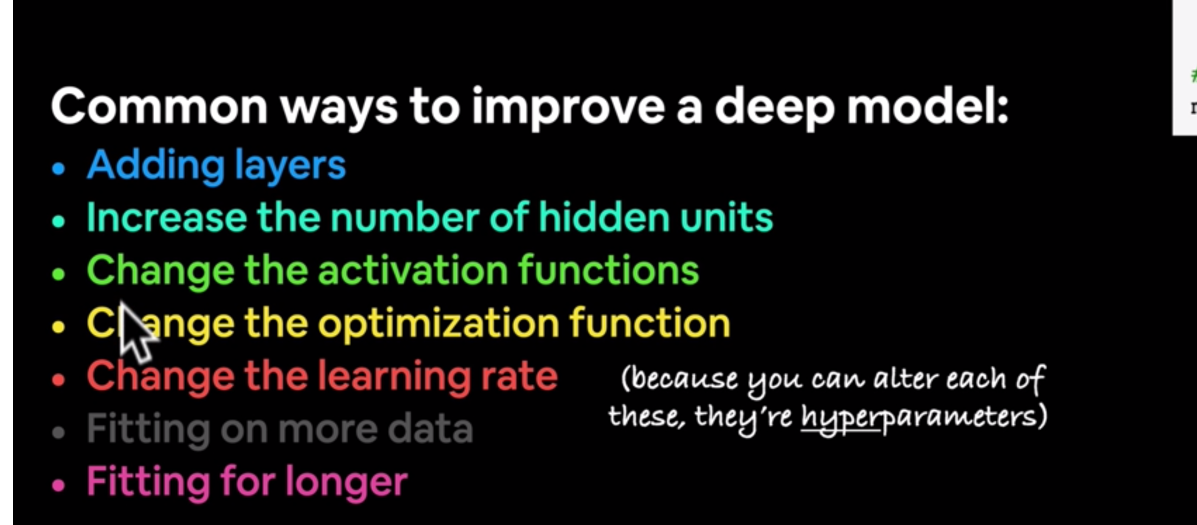

In [ ]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(shufllfed_augmented_data,
                        epochs=5,
                        steps_per_epoch=len(shufllfed_augmented_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 26s 515ms/step - loss: 0.6646 - accuracy: 0.5940 - val_loss: 0.5258 - val_accuracy: 0.7580
Epoch 2/5
47/47 [==============================] - 25s 526ms/step - loss: 0.5785 - accuracy: 0.7027 - val_loss: 0.4667 - val_accuracy: 0.7780
Epoch 3/5
47/47 [==============================] - 24s 510ms/step - loss: 0.5922 - accuracy: 0.6960 - val_loss: 0.4917 - val_accuracy: 0.7740
Epoch 4/5
47/47 [==============================] - 26s 562ms/step - loss: 0.5153 - accuracy: 0.7567 - val_loss: 0.4072 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 24s 513ms/step - loss: 0.5049 - accuracy: 0.7607 - val_loss: 0.4049 - val_accuracy: 0.8340


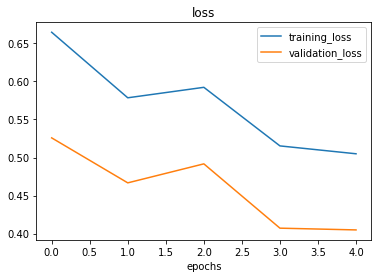

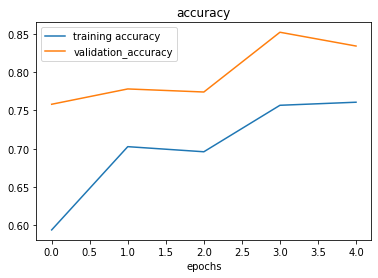

In [ ]:
# Check out the TinyVGG model performance
plot_loss_curves(history_8)

Hmm, our training curves are looking good, but our model's performance on the training and test sets didn't improve much compared to the previous model.

Taking another loook at the training curves, it looks like our model's performance might improve if we trained it a little longer (more epochs).

Perhaps that's something you like to try?

### Making a prediction with our trained model

What good is a trained model if you can't make predictions with it?

To really test it out, we'll upload a couple of our own images and see how the model goes.

First, let's remind ourselves of the classnames and view the image we're going to test on.